In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import bisect
import dask.dataframe as dd
from sklearn.metrics import mean_absolute_error
import pyarrow.csv as pv
import pyarrow.parquet as pq
import pycaret.classification as pc
from catboost import *

#### Создаем репрезентативную выборку, равную половине датасета

In [ ]:
#паркетная тема
'''df = dd.read_parquet('data/dataset.parquet')
df.to_csv('dataset-*.csv')

df = pv.read_csv('data/smoking.csv')
pq.write_table(df, 'data/smoking.csv'.replace('csv', 'parquet'))'''

In [ ]:
#df = dd.read_parquet('data/smoking.parquet')
df = dd.read_csv('data/smoking.csv')
print(df.columns)

df['age'] = df['age'].apply(lambda age: bisect.bisect_left([25,35,45,55,65],age))

gender_relation = (df.groupby('gender')['ID'].count().compute()/len(df)*100).values
age_relation = (df.groupby('smoking')['ID'].count().compute()/len(df)*100).values
print('должно быть:\n\n')
display(gender_relation)
display(age_relation)
display((df.groupby('age')['ID'].count().compute()/len(df)*100).values)

min_error = 1000
for seed in range(1,50):
    stratified_sample = df.groupby('age',group_keys= False).apply(lambda row: row.sample(frac=0.5,random_state=seed))

    st_gender_relation = (stratified_sample.groupby('gender')['ID'].count().compute()/len(stratified_sample)*100).values
    st_smoking_relation = (stratified_sample.groupby('smoking')['ID'].count().compute()/len(stratified_sample)*100).values
    error = mean_absolute_error(st_gender_relation,gender_relation) + mean_absolute_error(st_smoking_relation,age_relation)
    if error < min_error:
        min_error = error
        print(error, seed)
        print(st_gender_relation)
        print(st_smoking_relation)
print('end')

Альтернативный вариант репрезентативной выборки. И он mlя работает, это гениально

In [5]:
df = dd.read_csv('data/smoking.csv')
print(df.columns)

df['age'] = df['age'].apply(lambda age: bisect.bisect_left([25,35,45,55,65],age))

gender_relation = (df.groupby('gender')['ID'].count().compute()/len(df)*100).values
age_relation = (df.groupby('smoking')['ID'].count().compute()/len(df)*100).values
print(f'должно быть {len(df)}:\n\n')
display(gender_relation)
display(age_relation)
display((df.groupby('age')['ID'].count().compute()/len(df)*100).values)

#создаем колонку для стратификации
df['stratify_column'] = df['age'].astype(str) + "_" + df['gender'].astype(str) + df['smoking'].astype(str)

stratified_sample = df.groupby('stratify_column',group_keys= False).apply(lambda row: row.sample(frac=0.5))

st_gender_relation = (stratified_sample.groupby('gender')['ID'].count().compute()/len(stratified_sample)*100).values
st_smoking_relation = (stratified_sample.groupby('smoking')['ID'].count().compute()/len(stratified_sample)*100).values
st_age_relation = (stratified_sample.groupby('age')['ID'].count().compute()/len(stratified_sample)*100).values
print(f'получилось {len(stratified_sample)}:\n\n')
display(st_gender_relation)
display(st_smoking_relation)
display(st_age_relation)

Index(['ID', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental caries',
       'tartar', 'smoking'],
      dtype='object')


D:\ml\mts\venv\Lib\site-packages\dask\dataframe\core.py:4139: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('age', 'int64'))

  warnings.warn(meta_warning(meta))


должно быть 55692:




array([36.43431732, 63.56568268])

array([63.27120592, 36.72879408])

array([ 9.21137686, 15.3271565 , 39.89441931, 18.97759104, 13.472312  ,
        3.11714429])

C:\Users\koshk\AppData\Local\Temp\ipykernel_9820\988665730.py:16: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  stratified_sample = df.groupby('stratify_column',group_keys= False).apply(lambda row: row.sample(frac=0.5))


получилось 27847:




array([36.43121342, 63.56878658])

array([63.27072934, 36.72927066])

array([ 9.21104607, 15.3266061 , 39.88939563, 18.97870507, 13.47721478,
        3.11703236])

Сохраняем репрезентативную в csv

In [ ]:
stratified_sample = df.groupby('age',group_keys= False).apply(lambda row: row.sample(frac=0.5,random_state=31)).reset_index(drop=True)
stratified_sample.to_csv('stratified_sample-*.csv')

#### Работаем с выборкой в пандас

In [3]:
df = pd.read_csv('data/smoking.csv')
print(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,73.0,94.0,215.0,82.0,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,70.0,130.0,192.0,115.0,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,86.0,89.0,242.0,182.0,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,100.0,60.0,96.0,322.0,254.0,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,74.0,80.0,184.0,74.0,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,55676,F,40,170,65,75.0,0.9,0.9,1.0,1.0,110.0,68.0,89.0,213.0,99.0,75.0,118.0,12.3,1.0,0.6,14.0,7.0,10.0,Y,1,Y,0
55688,55681,F,45,160,50,70.0,1.2,1.2,1.0,1.0,101.0,62.0,89.0,166.0,69.0,73.0,79.0,14.0,1.0,0.9,20.0,12.0,14.0,Y,0,Y,0
55689,55683,F,55,160,50,68.5,1.0,1.2,1.0,1.0,117.0,72.0,88.0,158.0,77.0,79.0,63.0,12.4,1.0,0.5,17.0,11.0,12.0,Y,0,N,0
55690,55684,M,60,165,60,78.0,0.8,1.0,1.0,1.0,133.0,76.0,107.0,210.0,79.0,48.0,146.0,14.4,1.0,0.7,20.0,19.0,18.0,Y,0,N,0


In [4]:
df.loc[df['gender']== 'F','gender'] = 0
df.loc[df['gender']== 'M','gender'] = 1
df['gender'] = df['gender'].astype('int64')

df.loc[df['tartar']== 'N','tartar'] = 0
df.loc[df['tartar']== 'Y','tartar'] = 1
df['tartar'] = df['tartar'].astype('int64')

df['age'] = df['age'].apply(lambda age: bisect.bisect_left([25,35,45,55,65],age))

df = df.drop(['ID','oral'],axis=1)

print(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               55692 non-null  int64  
 1   age                  55692 non-null  int64  
 2   height(cm)           55692 non-null  int64  
 3   weight(kg)           55692 non-null  int64  
 4   waist(cm)            55692 non-null  float64
 5   eyesight(left)       55692 non-null  float64
 6   eyesight(right)      55692 non-null  float64
 7   hearing(left)        55692 non-null  float64
 8   hearing(right)       55692 non-null  float64
 9   systolic             55692 non-null  float64
 10  relaxation           55692 non-null  float64
 11  fasting blood sugar  55692 non-null  float64
 12  Cholesterol          55692 non-null  float64
 13  triglyceride         55692 non-null  float64
 14  HDL                  55692 non-null  float64
 15  LDL                  55692 non-null 

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,0,2,155,60,81.3,1.2,1.0,1.0,1.0,114.0,73.0,94.0,215.0,82.0,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0
1,0,2,160,60,81.0,0.8,0.6,1.0,1.0,119.0,70.0,130.0,192.0,115.0,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0
2,1,3,170,60,80.0,0.8,0.8,1.0,1.0,138.0,86.0,89.0,242.0,182.0,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1
3,1,2,165,70,88.0,1.5,1.5,1.0,1.0,100.0,60.0,96.0,322.0,254.0,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,1,0
4,0,2,155,60,86.0,1.0,1.0,1.0,1.0,120.0,74.0,80.0,184.0,74.0,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,0,2,170,65,75.0,0.9,0.9,1.0,1.0,110.0,68.0,89.0,213.0,99.0,75.0,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,1,0
55688,0,2,160,50,70.0,1.2,1.2,1.0,1.0,101.0,62.0,89.0,166.0,69.0,73.0,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,1,0
55689,0,3,160,50,68.5,1.0,1.2,1.0,1.0,117.0,72.0,88.0,158.0,77.0,79.0,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0,0,0
55690,1,4,165,60,78.0,0.8,1.0,1.0,1.0,133.0,76.0,107.0,210.0,79.0,48.0,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0,0,0


In [5]:
'''for column in df.columns:
    df[column].hist(bins=30)
    plt.title(column)
    plt.show()'''

'for column in df.columns:\n    df[column].hist(bins=30)\n    plt.title(column)\n    plt.show()'

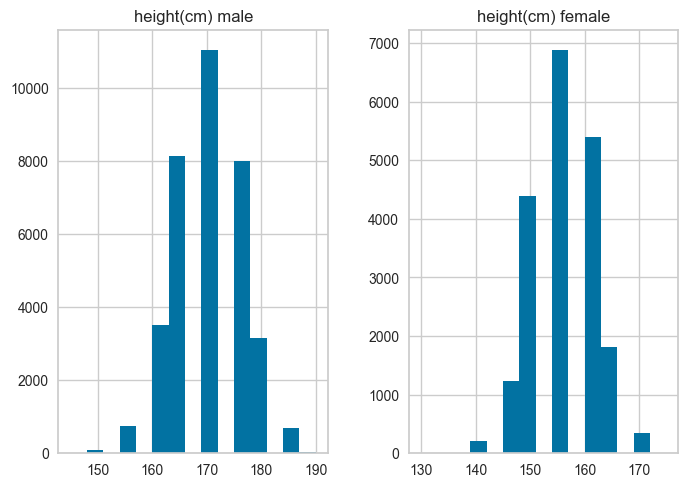

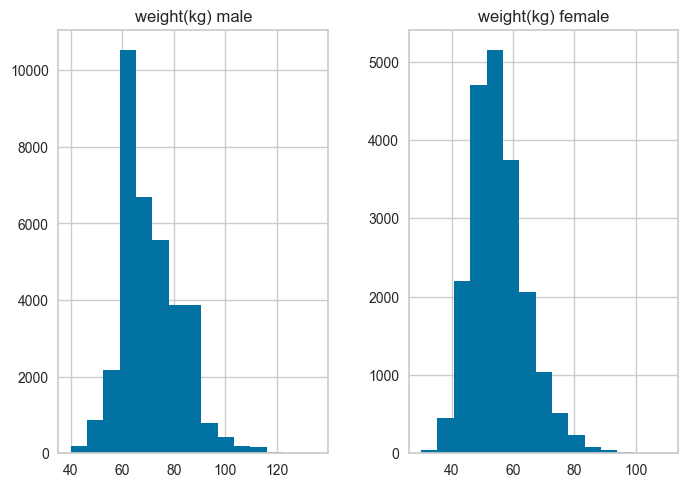

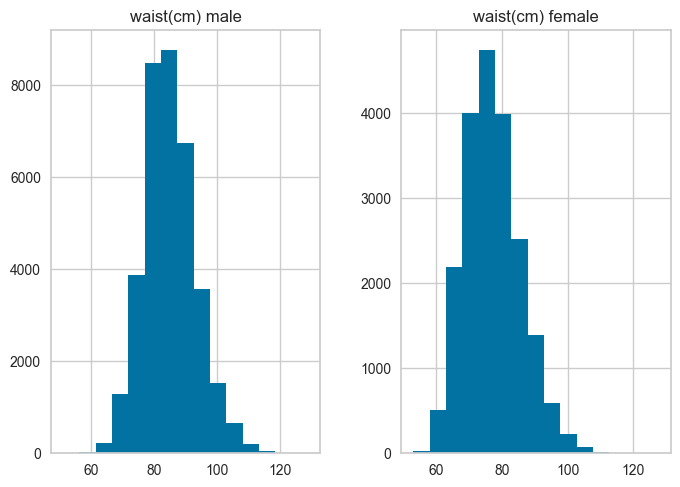

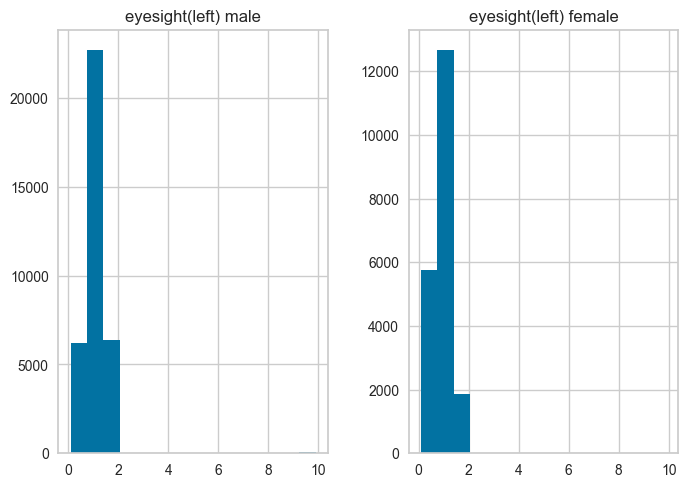

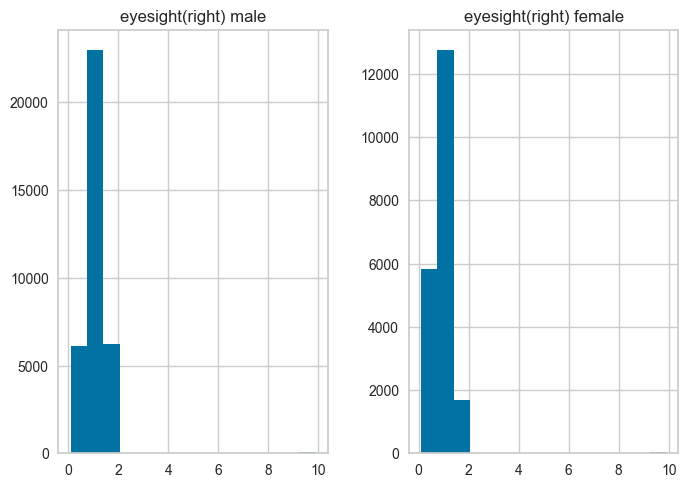

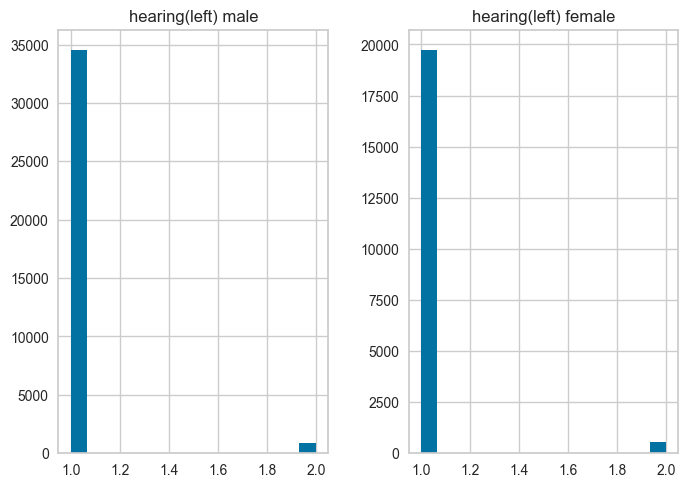

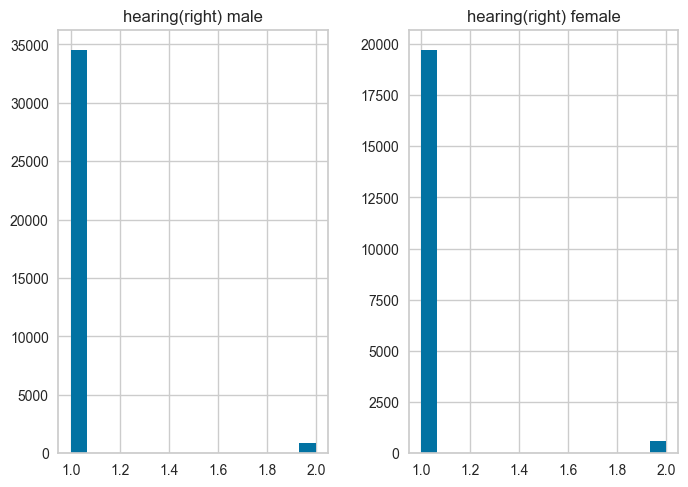

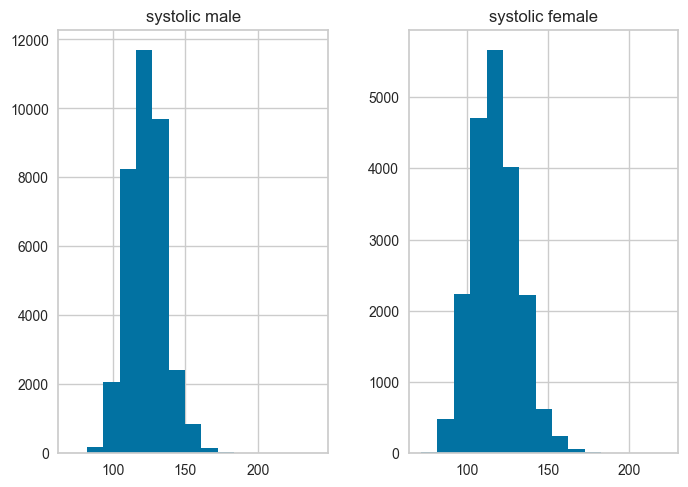

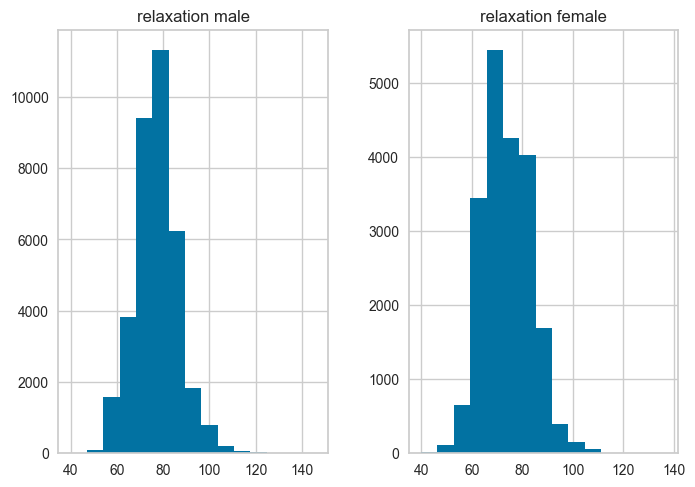

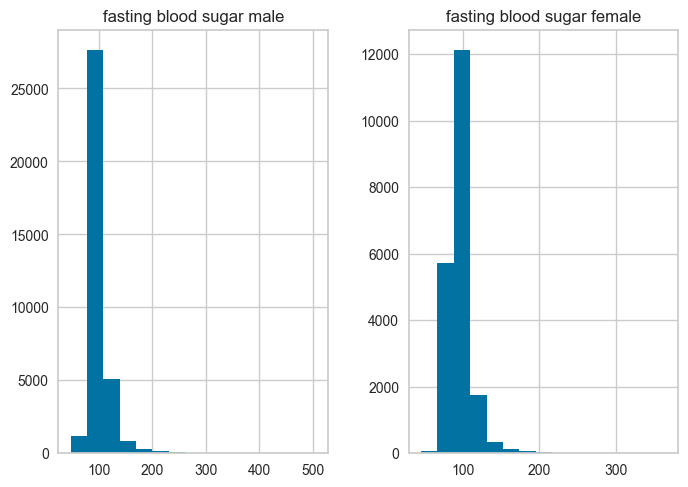

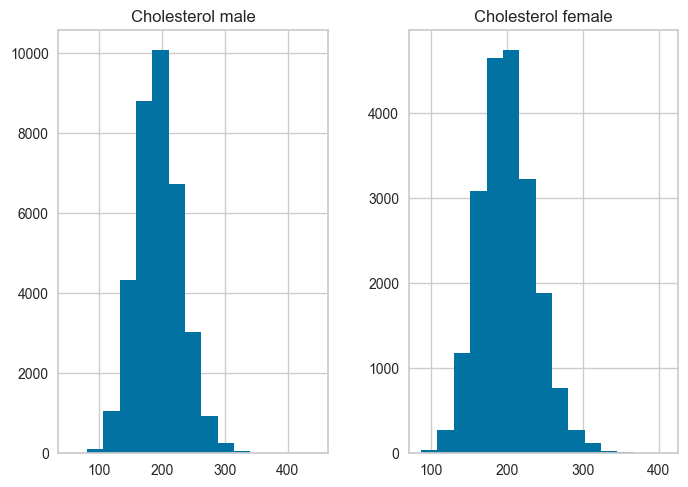

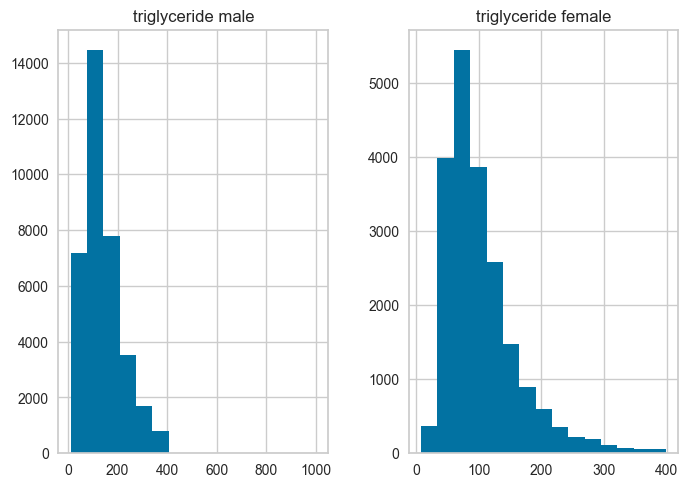

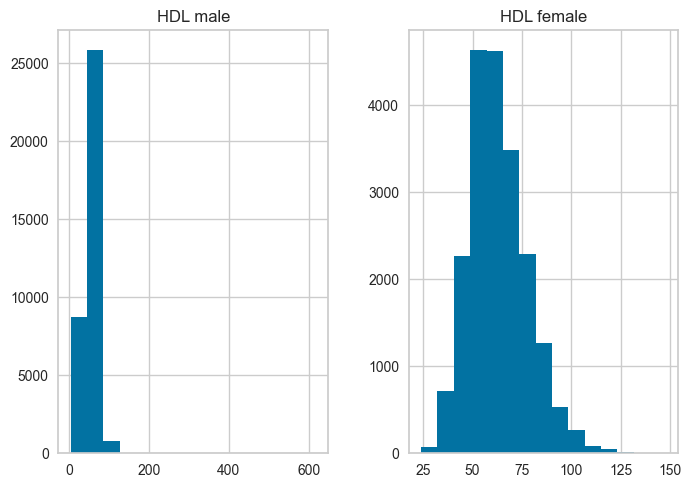

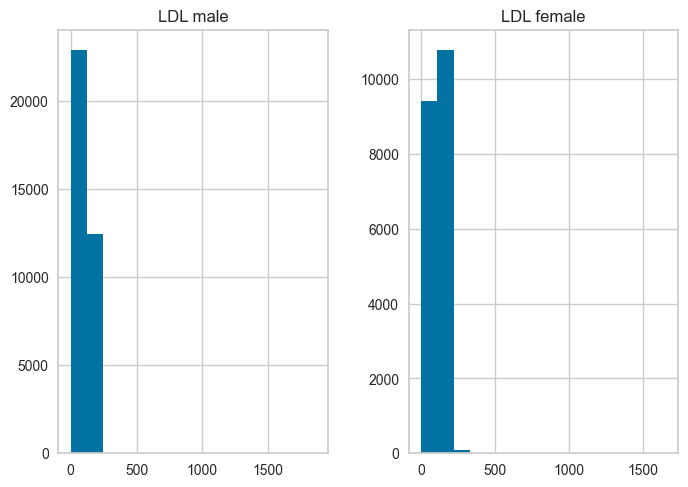

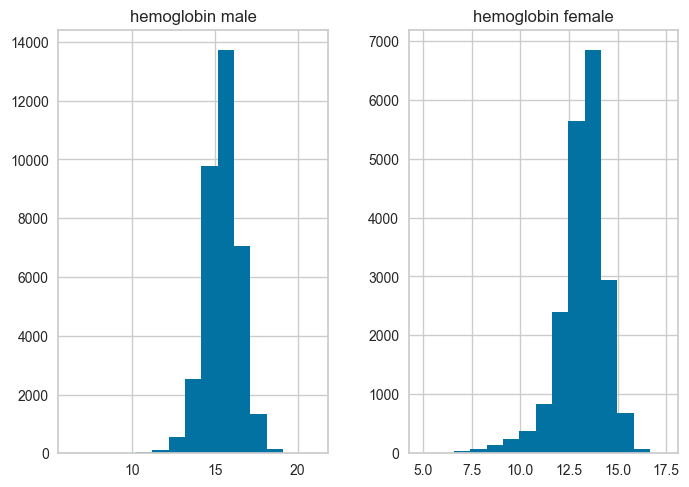

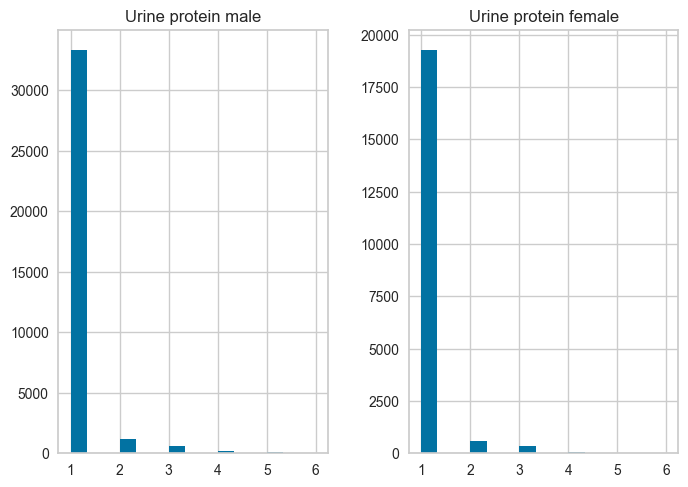

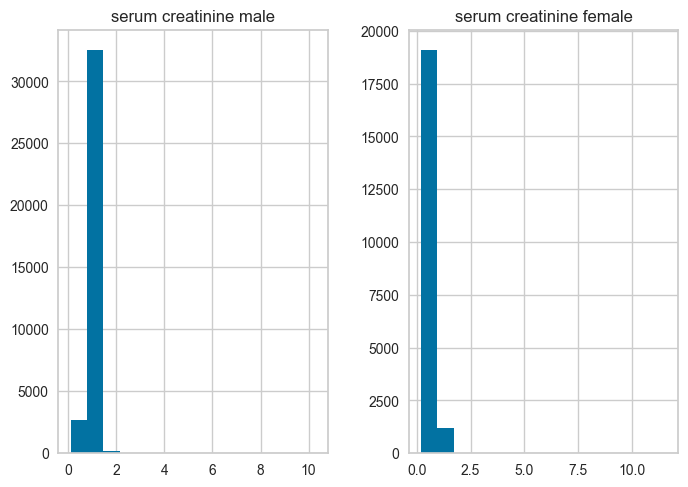

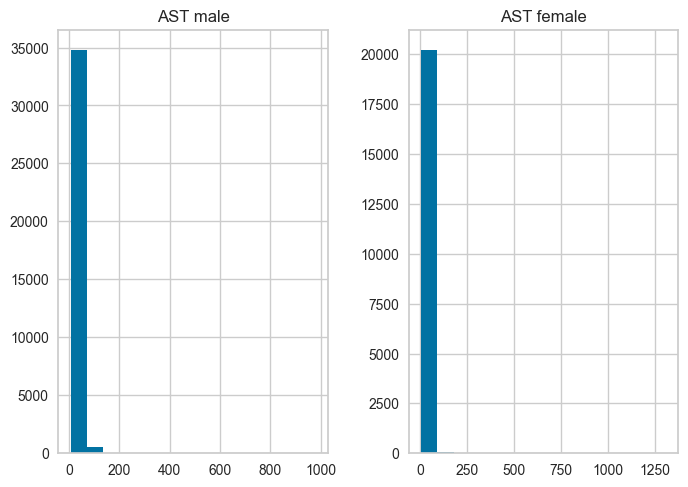

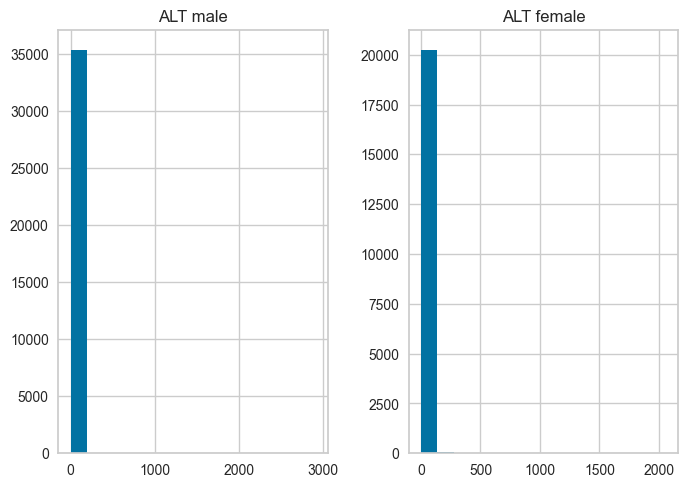

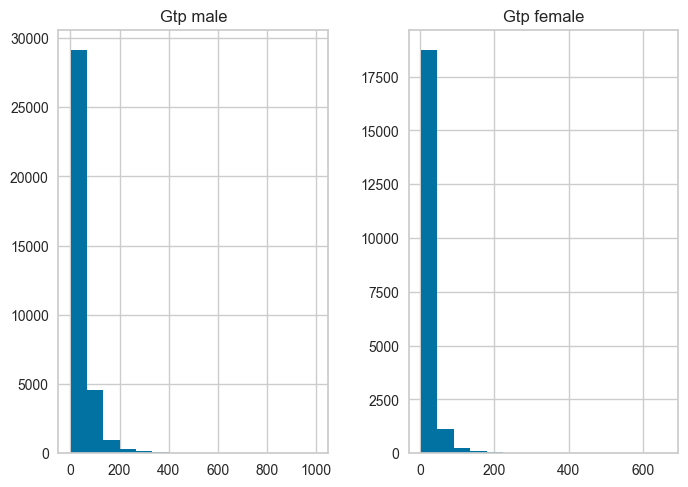

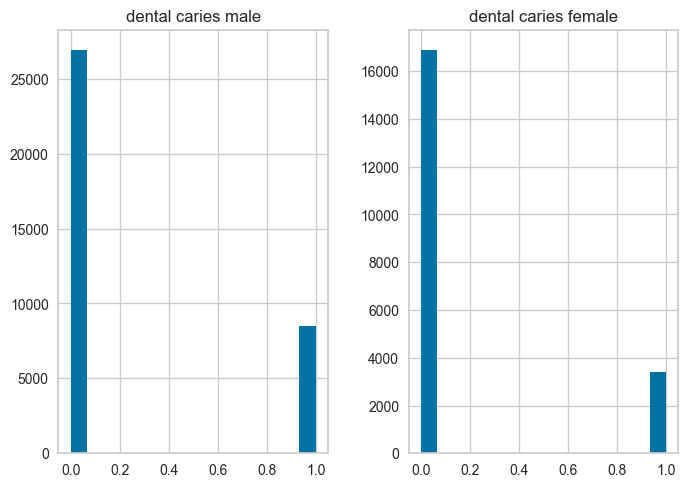

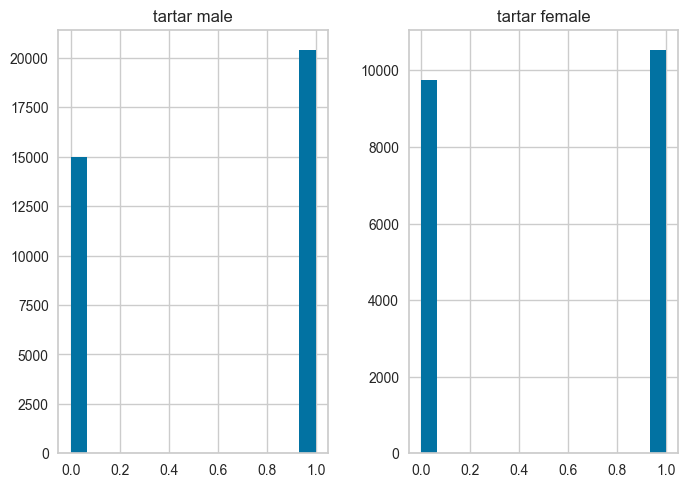

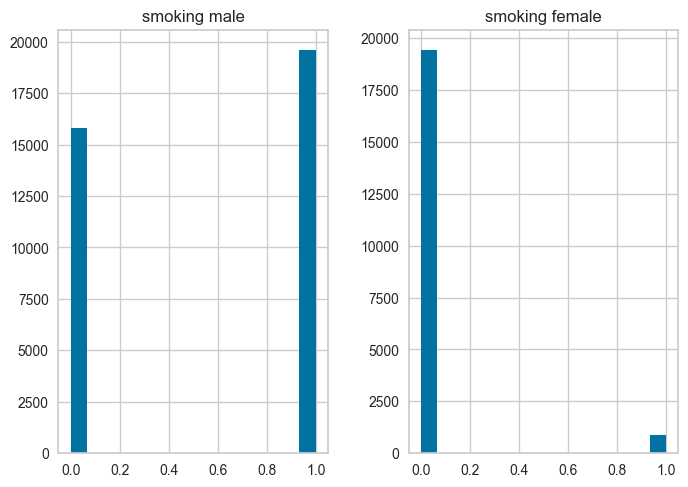

In [6]:
for column in df.drop(['age','gender'],axis=1):

    col1 = df.loc[df['gender']==1,column]
    col0 = df.loc[df['gender']==0,column]

    plot_data = {column+' male': col1,
                 column+' female': col0}

    plot_data = pd.concat(plot_data,axis = 1)
    plot_data.hist(bins=15)
    plt.show()

In [7]:
df_mean = df.groupby('gender').mean().T
df_mean['diff'] = abs(df_mean.loc[:,0] - df_mean.loc[:,1])/(df_mean.loc[:,1]/100)
display(df_mean)
df.drop(['hearing(left)','hearing(right)','Urine protein','LDL','Cholesterol'],axis=1)
display(df)

gender,0,1,diff
age,2.705042,1.934493,39.832045
height(cm),155.643389,169.811305,8.343329
weight(kg),56.128826,71.445439,21.438197
waist(cm),76.906791,84.992328,9.513255
eyesight(left),0.930679,1.059592,12.166284
eyesight(right),0.926770,1.053682,12.044583
hearing(left),1.027549,1.024463,0.301287
hearing(right),1.028584,1.024745,0.374633
systolic,118.472328,123.226293,3.857915
relaxation,73.730521,77.308409,4.628071


,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,0,2,155,60,81.3,1.2,1.0,1.0,1.0,114.0,73.0,94.0,215.0,82.0,73.0,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0
1,0,2,160,60,81.0,0.8,0.6,1.0,1.0,119.0,70.0,130.0,192.0,115.0,42.0,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0
2,1,3,170,60,80.0,0.8,0.8,1.0,1.0,138.0,86.0,89.0,242.0,182.0,55.0,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1
3,1,2,165,70,88.0,1.5,1.5,1.0,1.0,100.0,60.0,96.0,322.0,254.0,45.0,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,1,0
4,0,2,155,60,86.0,1.0,1.0,1.0,1.0,120.0,74.0,80.0,184.0,74.0,62.0,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,0,2,170,65,75.0,0.9,0.9,1.0,1.0,110.0,68.0,89.0,213.0,99.0,75.0,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,1,0
55688,0,2,160,50,70.0,1.2,1.2,1.0,1.0,101.0,62.0,89.0,166.0,69.0,73.0,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,1,0
55689,0,3,160,50,68.5,1.0,1.2,1.0,1.0,117.0,72.0,88.0,158.0,77.0,79.0,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0,0,0
55690,1,4,165,60,78.0,0.8,1.0,1.0,1.0,133.0,76.0,107.0,210.0,79.0,48.0,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0,0,0


#### Вывод - кикаем hearing, urine protein, LDL, Cholesterol для определения пола

# Данные подготовлены, работаем, братья

In [8]:
s = pc.setup(df, target='gender',train_size=0.8, session_id=12345)

,Description,Value
0,session_id,12345
1,Target,gender
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(55692, 25)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [9]:
best = pc.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9808,0.9977,0.9846,0.9852,0.9849,0.9586,0.9586,0.6750
catboost,CatBoost Classifier,0.9806,0.9979,0.9833,0.9862,0.9847,0.9583,0.9583,4.6260
et,Extra Trees Classifier,0.9799,0.9978,0.9833,0.9850,0.9841,0.9566,0.9566,0.4980
lightgbm,Light Gradient Boosting Machine,0.9797,0.9978,0.9833,0.9848,0.9840,0.9562,0.9563,0.1810
ada,Ada Boost Classifier,0.9740,0.9969,0.9788,0.9803,0.9795,0.9440,0.9440,0.3330
gbc,Gradient Boosting Classifier,0.9739,0.9967,0.9790,0.9799,0.9795,0.9438,0.9438,1.2910
lr,Logistic Regression,0.9690,0.9950,0.9751,0.9760,0.9756,0.9330,0.9331,1.3340
dt,Decision Tree Classifier,0.9675,0.9650,0.9745,0.9745,0.9745,0.9300,0.9300,0.0810
lda,Linear Discriminant Analysis,0.9608,0.9939,0.9675,0.9708,0.9691,0.9156,0.9156,0.0960
ridge,Ridge Classifier,0.9607,0.0000,0.9677,0.9704,0.9690,0.9153,0.9154,0.0320
